# Power/inverse iteration

## Rayleigh quotient

Suppose $A$ is $m\times m$. We can define a function called the **Rayleigh quotient**,

$$ r(v) = \frac{v^*Av}{v^*v}, $$

for all $v\in\mathbb{C}^m$. As shown in the text, if $A$ is hermitian then the eigenvectors of $A$ the stationary points of $r$. More specifically, if $v$ is close to an eigenvector $x$ with eigenvalue $\lambda$, then 

$$ |r(v)-\lambda| = O\bigl( \|v-x\|_2 \bigr) $$

in general, and 

$$ |r(v)-\lambda| = O\bigl( \|v-x\|_2^2 \bigr) $$

if $A$ is hermitian. Thus we can turn an eigenvector estimate into an eigenvalue estimate, and in the hermitian case, the eigenvalue estimate is *much* more accurate than the eigenvector is. (It's like going from 3 digits to 6, for instance.)

For example, let

In [2]:
using LinearAlgebra
A = [2 1 1; 1 3 1; 1 1 4]

3×3 Array{Int64,2}:
 2  1  1
 1  3  1
 1  1  4

In [5]:
(λ,X) = eigen(A);
@show λ;

λ = [1.32487, 2.46081, 5.21432]


In [6]:
X

3×3 Array{Float64,2}:
  0.88765   -0.233192  -0.397113
 -0.427132  -0.739239  -0.520657
 -0.172148   0.631781  -0.755789

The max of $r(v)$ is the third eigenvector of $A$ as computed above, and close to $(0.4,0.5,0.75)$. 

In [8]:
x = X[:,3];  
v = [0.4;0.5;0.75];
evec_err = norm(-x-v)

0.02164672504409101

In [9]:
eval_est = v'*A*v/(v'*v)
eval_err = norm(eval_est-λ[3])

0.0009521341230360747

In logarithmic terms (i.e. number of digits), we see the error roughly double. 

In [11]:
@show log(10,evec_err);
@show log(10,eval_err);

log(10, evec_err) = -1.664607799211983
log(10, eval_err) = -3.021301870111707


## Power iteration

Now that we can turn an eigenvector estimate into an eigenvalue estimate, we turn to finding an eigenvector. Clearly, if $A=XDX^{-1}$ and $k$ is a positive integer, then $A^k=XD^kX^{-1}$. That is, $A$ and $A^k$ share the same eigenvectors, but the eigenvalues of $A^k$ are raised to the $k$th power. So if there is an eigenvalue $\lambda_1$ such that $|\lambda_1|>|\lambda_j|$ for all $j>1$, the ratio $|\lambda_1/\lambda_j|^k\to 0$ as $k\to\infty$, and in that case $A^kv$ is dominated by the eigenvector $x_1$ that belongs with $\lambda_1$, for practically *any* vector $v$. This leads us to the **power iteration**.

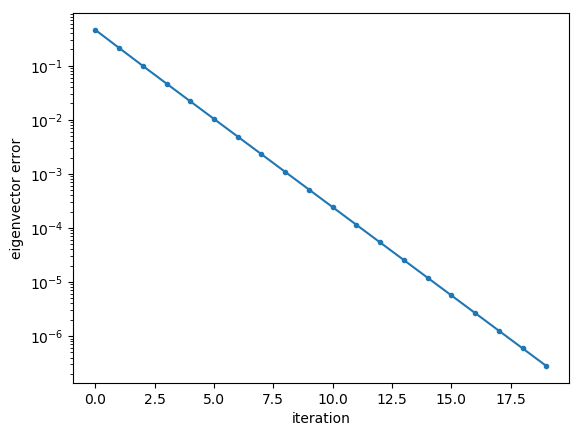

PyObject Text(24,0.5,'eigenvector error')

In [13]:
v = rand(3);
evec_err = [];
for k = 1:20
    v = v/norm(v);
    evec_err = [evec_err;min(norm(v-x),norm(v+x))];
    v = A*v;
end
using PyPlot
semilogy(evec_err,".-");
xlabel("iteration");
ylabel("eigenvector error");

We call this **linear convergence**. It's a straight line (as iteration goes to infinity) on a log-linear graph, or equivalently, a reduction in error by a constant factor at each step. I.e., if you suppose that $y_n \approx CK^n$ for some $K<1$, then $\log y_n \approx (\log C) + n(\log K)$. 

In [14]:
evec_err[2:end]./evec_err[1:end-1]

19-element Array{Float64,1}:
 0.46492032262305677
 0.4659422879527287 
 0.4695817773883658 
 0.47114432530006395
 0.4716832800226633 
 0.4718562916008917 
 0.47190998526650246
 0.471926322564467  
 0.47193122912580754
 0.4719326893307754 
 0.4719331210389694 
 0.4719332480554397 
 0.4719332852901644 
 0.47193329617479435
 0.4719332993515568 
 0.4719333002656376 
 0.4719333005250147 
 0.47193330057377186
 0.47193330059086597

Since $A$ is symmetric, the final $v$ we got above should give an RQ eigenvalue estimate with about 12 accurate digits. 

In [15]:
abs( v'*A*v/(v'*v) - λ[3] )

4.884981308350689e-14

Now how much would you pay? But wait—there's more!

## Inverse iteration

If $\lambda_J$ is an eigenvalue of $A$, then $(\lambda_J-\mu)^{-1}$ is an eigenvalue of $(A-\mu I)^{-1}$, with the same eigenvector. If $\mu$ is closer to $\lambda_J$ than to any other $\lambda_j$, a power iteration on $(A-\mu I)^{-1}$ should converge very quickly. This amounts to repeatedly solving a linear system with the matrix $(A-\mu I)$.

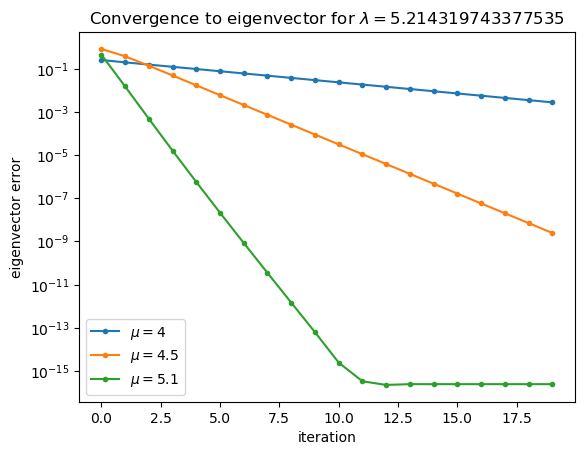

In [28]:
for mu = [4 4.5 5.1]
    LU = lu(A-mu*I);
    v = rand(3,1);
    for k = 1:20
        v = v/norm(v);
        evec_err[k] = min(norm(v-x),norm(v+x));
        v = LU\v;
    end
    semilogy(evec_err,".-")
end
xlabel("iteration");
ylabel("eigenvector error");
using LaTeXStrings
legend([L"\mu=4",L"\mu=4.5",L"\mu=5.1"]);
title("Convergence to eigenvector for \$\\lambda=$(λ[3])\$");

## Rayleigh quotient iteration

The coup de grâce is a positive feedback loop: a better shift means a better eigenvector estimate, which means a better eigenvalue estimate, which is an even better shift, etc. 

Suppose that $v=x_J+ w$ for some $w$ made up of components of the other eigenvectors, and $\|w\|=\epsilon < 1$. The RQ turns this into an eigenvector estimate/shift $\mu$ with  $|\mu-\lambda_J|=O(\epsilon)$ as well. Say that $\mu$ is $O(1)$ away from other eigenvalues (the following is all true in that relative sense). Then one step of inverse iteration leaves us with an improved eigenvector such that $\|v-x_J\|= O(\epsilon \|w\|)=O(\epsilon^2)$. This is **quadratic convergence**, which is very fast; the number of accurate digits goes 1, 2, 4, 8, 16, done.  

In the hermitian case, starting with $\|w\|=\epsilon$ means that $|\mu-\lambda_J|=O(\epsilon^2)$ initially, and the eigenvector improves to $\|v-x_J\|= O(\epsilon^2 \|w\|)=O(\epsilon^3)$. This is **cubic** convergence, which is ludicrously fast. It's so fast that we pretty much need extended precision even to verify it.

In [33]:
setprecision(333)  # about 100 decimal digits
A = BigFloat.(A)
v = ones(BigFloat,3)
mu = []
for k = 1:6
    v = v/norm(v)
    mu = [mu; dot(v,A*v)]
    v = (A-mu[k]*I)\v  
end

println("error in eigenvalue estimates: ")
[@show(mu[i]-mu[end]) for i=1:5]

error in eigenvalue estimates: 
mu[i] - mu[end] = -2.14319743377535187415497700848580488907919637219499434331382316509128046433266274795971250341964351609e-01
mu[i] - mu[end] = -1.20498927917453167779278281579360366201799787523713924941510339437394807261053709105321755507910606706e-03
mu[i] - mu[end] = -1.93503356367048850526333735019219564576652064357886234263140722401199652588526026768093013483678965731e-10
mu[i] - mu[end] = -8.62720410876475370787412876031120398307176384963983167324968326442616974082305039425385331097687301172e-31
mu[i] - mu[end] = -8.01195697477183331415562741814076441241821430695636084691256004687694181477159941614728193147148954275e-92


5-element Array{BigFloat,1}:
 -2.14319743377535187415497700848580488907919637219499434331382316509128046433266274795971250341964351609e-01
 -1.20498927917453167779278281579360366201799787523713924941510339437394807261053709105321755507910606706e-03
 -1.93503356367048850526333735019219564576652064357886234263140722401199652588526026768093013483678965731e-10
 -8.62720410876475370787412876031120398307176384963983167324968326442616974082305039425385331097687301172e-31
 -8.01195697477183331415562741814076441241821430695636084691256004687694181477159941614728193147148954275e-92

Count 'em: The number of leading zeros *at least triples* with each iteration, and in 5 iterations we get 90 digits of accuracy. 😎